# RNN from scratch using TensorFlow

<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/rnn.jpg">

In this example, we'll build a simple RNN using TensorFlow and we'll train the RNN to add two binary numbers.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
%pylab inline

pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


First, we make some training data. To keep things simple, we'll only pick numbers between 0 and $2^6$, so that the sum of the two numbers are less than $2^7$.

In [2]:
max_digits = 6
n_samples = 10000
ints = np.random.randint(low=0, high=np.power(2, max_digits), size=[n_samples, 2])
data_df = pd.DataFrame(ints, columns=['x1', 'x2'])

In [3]:
data_df.head()

,x1,x2
0,13,37
1,9,5
2,63,31
3,58,11
4,30,29


In [4]:
data_df = data_df.assign(y=data_df.x1 + data_df.x2)

In [5]:
data_df.head()

,x1,x2,y
0,13,37,50
1,9,5,14
2,63,31,94
3,58,11,69
4,30,29,59


The next step is to convert all the decimal numbers to their binary array representations. For this we'll use the `numpy.unpackbits` function. 

In [6]:
np.unpackbits(np.array(10, dtype=np.uint8))

array([0, 0, 0, 0, 1, 0, 1, 0], dtype=uint8)

First y. The 5000 y values become a $1 \times 8 \times 5000$ 2D array.

In [7]:
y_data = np.unpackbits(data_df.y.astype(np.uint8))
y_data =y_data.astype(np.float64).reshape(n_samples, 8, 1)
y_data = np.transpose(y_data, axes=[1, 0, 2])

np.packbits(y_data[:, 0, :].astype(np.int64))

array([50], dtype=uint8)

In [8]:
y_data.shape

(8, 10000, 1)

Similarly, the 5000 x1 and x2 values become an $8 \times 5000 \times$ 2 3D array.

In [9]:
x_data = np.zeros([2, n_samples, 8], dtype=np.uint8)

x_data[0, :, :] = np.unpackbits(data_df.x1.astype(np.uint8)).reshape(n_samples, 8)
x_data[1, :, :] = np.unpackbits(data_df.x2.astype(np.uint8)).reshape(n_samples, 8)

x_data = x_data.astype(np.float64)
x_data = np.transpose(x_data, axes=[2, 1, 0])

np.packbits(x_data[:, 0, :].T.astype(np.int64))

array([13, 37], dtype=uint8)

In [10]:
x_data.shape

(8, 10000, 2)

In [26]:
# Build the RNN graph
hidden_dim = 3

tf.reset_default_graph()

with tf.variable_scope('input'):
    x_in = tf.placeholder(shape=(8, n_samples, 2), dtype=np.float64, name='x')
    y_in = tf.placeholder(shape=(8, n_samples, 1), dtype=np.float64, name='y')

with tf.variable_scope('hidden'):
    # Check dimensions
    w_f = tf.get_variable(shape=[hidden_dim, 1], dtype=np.float64, 
                      initializer=tf.truncated_normal_initializer(), 
                      name='w_f')
    w_h = tf.get_variable(shape=[2, hidden_dim], dtype=np.float64, 
                      initializer=tf.truncated_normal_initializer(), 
                     name='w_h')
    u_h = tf.get_variable(shape=[1, hidden_dim], dtype=np.float64, 
                      initializer=tf.truncated_normal_initializer(),
                     name='u_h')
    
    b_f = tf.get_variable(shape=[1, 1], dtype=np.float64, 
                      initializer=tf.zeros_initializer(), 
                      name='b_f')
    b_h = tf.get_variable(shape=[1, hidden_dim], dtype=np.float64, 
                      initializer=tf.zeros_initializer(), 
                      name='b_h')

with tf.variable_scope('output'):
    y_t = tf.get_variable(shape=(n_samples, 1), dtype=np.float64, 
                          initializer=tf.zeros_initializer(), name='y_t')
    y_out = []
    
    x_pos = tf.unstack(x_in, axis=0) 
    # x_pos is a tensor of length 8, each item 5000 * 2
    
    y_pos = tf.unstack(y_in, axis=0) 
    # y_pos is a tensor of length 8, each item 5000 * 1
    
    # reverse both x_pos and y_pos because 
    # we want to start at the LSB and work our way to the MSB
    for x, y in zip(reversed(x_pos), reversed(y_pos)):
        # dim check
        # x: [5000, 2], w_h: [2, 3] -> tf.matmul(x, w_h): [5000, 3]
        # y_t: [5000, 1], u_h: [1, 3] -> tf.matmul(y_t, u_h): [5000, 3]
        # b_h: [1, 3] is broadcast into the sum
        # finally, h_t: [5000, 3]
        h_t = tf.nn.sigmoid(tf.matmul(x, w_h) + tf.matmul(y_t, u_h) + b_h, name='h_t')
        
        # dim check
        # w_f: [3, 1] -> tf.matmul(h_t, w_f): [5000, 1]
        # b_f is again broadcast
        y_t = tf.nn.sigmoid(tf.matmul(h_t, w_f) + b_f, name='y_t')
        y_out.append(y_t)
        
with tf.variable_scope('loss'):
    losses = []
    for y_calc, y_actual in zip(y_out, reversed(y_pos)):       
        loss = tf.squared_difference(y_calc, y_actual)
        losses.append(loss)
        
    optimizer = tf.train.AdamOptimizer(learning_rate=0.04)
    mean_loss = tf.reduce_mean(losses, name='ms_loss')
    train_op = optimizer.minimize(mean_loss, name='minimization')
        
init = tf.global_variables_initializer()

n_training_iters = 2000

with tf.Session() as sess:
    sess.run(init) 
    
    for i in range(1, n_training_iters+1):
        _, loss_val = sess.run([train_op, mean_loss], feed_dict={x_in: x_data, y_in: y_data})

        if i == 1 or i % 100 == 0:
            print(i, loss_val)
            
    y_out_vals = sess.run(y_out, feed_dict={x_in: x_data, y_in: y_data})
    

1 0.276770490903
100 0.216759928338
200 0.208132325993
300 0.205026104057
400 0.201898073655
500 0.20100555917
600 0.200700495417
700 0.200278464797
800 0.197584750055
900 0.192247372264
1000 0.185061663138
1100 0.182831077603
1200 0.181365569987
1300 0.180268048363
1400 0.179816693073
1500 0.179464499267
1600 0.180120917316
1700 0.179113022599
1800 0.178714259609
1900 0.178427977678
2000 0.178198863741


In [28]:
len(y_out_vals)

8

In [29]:
y_out_t = np.array(y_out_vals)[:, :, 0]

In [30]:
y_out_f = np.fliplr(y_out_t.T)

In [31]:
y_out_int = np.where(y_out_f > 0.5, 1, 0).astype(np.uint8)

In [32]:
nums = np.packbits(y_out_int)

In [33]:
nums

array([ 60,  28, 126, ...,  63,  62, 126], dtype=uint8)

In [34]:
results = pd.DataFrame({'sum_actual': data_df.y, 'sum_predicted': nums})

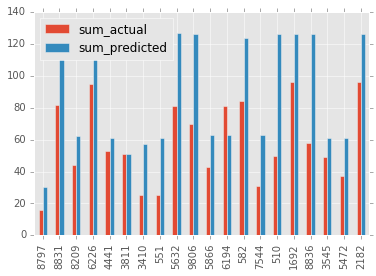

In [35]:
results.sample(20).plot(kind='bar')

In [36]:
results.tail(20)

,sum_actual,sum_predicted
9980,55,127
9981,60,62
9982,47,111
9983,88,126
9984,99,127
9985,83,123
9986,26,22
9987,89,127
9988,41,103
9989,63,63


In [37]:
results.corr()

,sum_actual,sum_predicted
sum_actual,1.000000,0.706588
sum_predicted,0.706588,1.000000
